In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/Others/Machine Learning/Final Project/Employee TurnOverAnalystics/'

!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Others/Machine Learning/Final Project/Employee TurnOverAnalystics
1722506171_employee_turnover_problem_statement.pdf  1722506184_hr_comma_sep.zip  HR_comma_sep.csv


In [2]:
class Employee:

  def __init__(self):
    self.df = pd.read_csv('HR_comma_sep.csv')
    self.df_dataset = self.df.copy()

  def get_dataset(self):
    if 'Unnamed: 0' in self.df_dataset.columns:
      self.df_dataset = self.df_dataset.drop(['Unnamed: 0'], axis=1)


    return self.df_dataset

  def dataset_Overview(self):
    print('-'*100)
    df_rows, df_col = self.df_dataset.shape
    print(f'The dataset has {df_rows} rows and {df_col} columns')
    print('-'*100)

    print('Info \n', self.df_dataset.info())
    print('-'*100)

    print('Describe \n', self.df_dataset.describe().T)
    print('-'*100)

  def Check_for_null_values(self):
    null_count = self.df_dataset.isnull().sum()
    nan_count = self.df_dataset.isna().sum()

    for col_name in self.df_dataset.columns:
      if self.df_dataset[col_name].dtype != 'object':
        if (self.df_dataset[col_name].isnull().sum().any()):
          self.df_dataset[col_name].fillna(self.df_dataset[col_name].mean()[0],inplace=True)
        elif (self.df_dataset[col_name].isna().sum().any()):
          self.df_dataset[col_name].fillna(self.df_dataset[col_name].mean()[0],inplace=True)
        else:
          print(f'No Null or NaN values found in the dataset column {col_name}')

    return self.df_dataset

  def Check_For_Duplicates(self):
    duplicate_entries = self.df_dataset[self.df_dataset.duplicated()]

    if not duplicate_entries.empty:
      print('There are duplicate entries in the dataset\n',duplicate_entries.shape)
      print('Removing duplicate entries')
      self.df_dataset = self.df_dataset.drop_duplicates(keep='first')
      print('Duplicate entries removed current shape of the dataset, Rows', self.df_dataset.shape[0],' and the columns ',self.df_dataset.shape[1])
    else:
      print('There are no duplicate entries in the dataset\n')

    return self.df_dataset

  def Replace_Infinity_Value(self):
    inf_columns = self.df_dataset.columns[self.df_dataset.isin([np.inf, -np.inf]).any()]
    print(inf_columns.to_list())
    if inf_columns.any():
      self.df_dataset[inf_columns] = self.df_dataset[inf_columns].replace([np.inf, -np.inf], np.nan)
      for col in inf_columns:
        print(f'Column {col} has infinte data value so replacing with mean value')
        self.df_dataset[col].fillna(self.df_dataset[col].mean(),inplace=True)

    else:
      print('There are no infinity values in the dataset\n')
    return self.df_dataset





ObjEmp = Employee()
df_Employee= ObjEmp.get_dataset()


In [3]:
df_Employee.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
df_Employee = ObjEmp.dataset_Overview()

----------------------------------------------------------------------------------------------------
The dataset has 14999 rows and 10 columns
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int

In [5]:
df_Employee = ObjEmp.Check_for_null_values()

No Null or NaN values found in the dataset column satisfaction_level
No Null or NaN values found in the dataset column last_evaluation
No Null or NaN values found in the dataset column number_project
No Null or NaN values found in the dataset column average_montly_hours
No Null or NaN values found in the dataset column time_spend_company
No Null or NaN values found in the dataset column Work_accident
No Null or NaN values found in the dataset column left
No Null or NaN values found in the dataset column promotion_last_5years


In [6]:
df_Employee = ObjEmp.Replace_Infinity_Value()

[]
There are no infinity values in the dataset



In [7]:
df_Employee = ObjEmp.Check_For_Duplicates()


There are duplicate entries in the dataset
 (3008, 10)
Removing duplicate entries
Duplicate entries removed current shape of the dataset, Rows 11991  and the columns  10


In [8]:
class PlotTheGraph():
  def __init__(self,df):
    self.df = df_Employee

  def PlotHeatmap(self):
    corelation_Matrix = self.df.select_dtypes(include=[np.number]).corr()
    plt.figure(figsize=(10,10))
    sns.heatmap(corelation_Matrix,cmap='Spectral',annot=True,linewidths=0.5)
    plt.show()

  def HistplotDistribution(self):
    columns_header = ["satisfaction_level","last_evaluation","average_montly_hours"]
    plt.figure(figsize=(15,10))
    for indx, col_plt in enumerate(columns_header):
      plt.subplot(len(columns_header)//3+1,3,indx+1)
      sns.histplot(self.df[col_plt],kde = True)

      plt.title(f'Distribution of {col_plt}')
      plt.tight_layout()
    plt.show()

  def BarplotGraph(self):
    plt.figure(figsize=(5,5))
    sns.barplot(x='number_project',y='left',data=self.df)
    plt.title('Bar Plot of Employee Project Count by Left Status')
    plt.tight_layout()
    plt.show()





pltgrpaph = PlotTheGraph(df_Employee)


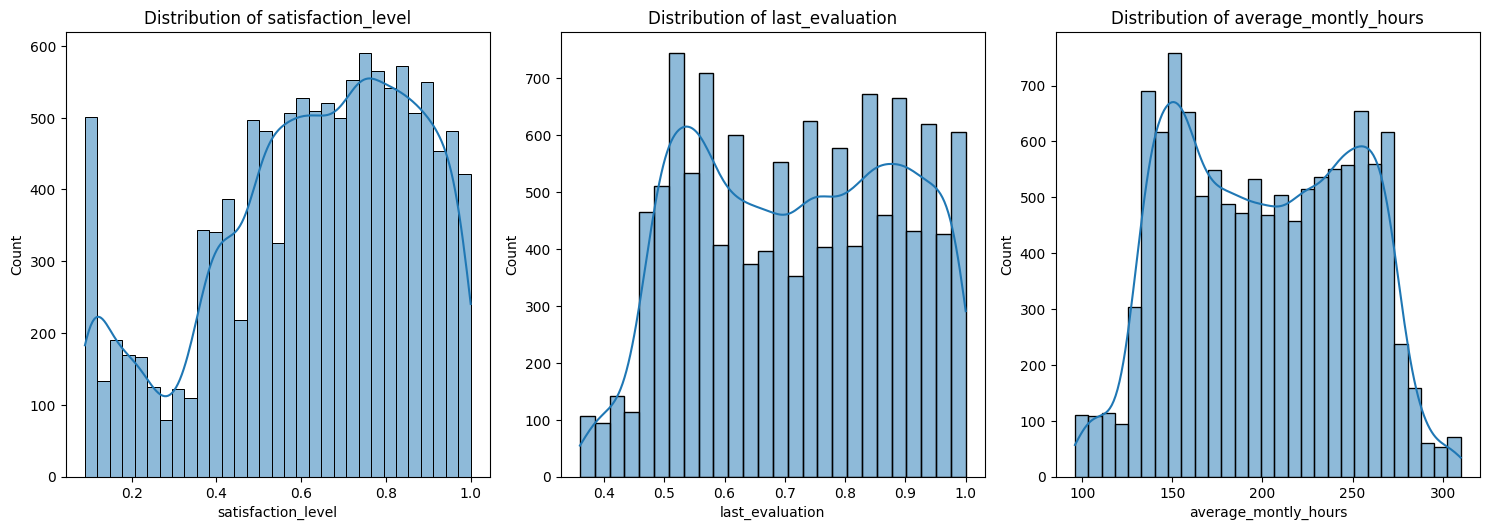

'\nEmployee Satisfaction (satisfaction_level):\n\nThe distribution appears to be bimodal, with peaks around 0.1 and 0.8.\n\nThis indicates that there are two distinct groups of employees: one group with low satisfaction levels and another with high satisfaction levels.\n\nEmployee Evaluation (last_evaluation):\n\nThe distribution has a peak around 0.5 and another around 0.85.\n\nThis suggests that many employees receive evaluations around these two points, possibly indicating a split between average and high performers.\n\nEmployee Average Monthly Hours (average_montly_hours):\n\nThe distribution is bimodal, with peaks around 150 and 250 hours.\n\nThis indicates that there are two groups of employees: one working fewer hours per month and another working significantly more hours.\n\nBar Plot of Employee Project Count by Left Status\nThe bar plot compares the number of projects for employees who left the organization versus those who stayed.\n\nObservation:\n\nEmployees with a high numb

In [9]:
pltgrpaph.HistplotDistribution()
'''
Employee Satisfaction (satisfaction_level):

The distribution appears to be bimodal, with peaks around 0.1 and 0.8.

This indicates that there are two distinct groups of employees: one group with low satisfaction levels and another with high satisfaction levels.

Employee Evaluation (last_evaluation):

The distribution has a peak around 0.5 and another around 0.85.

This suggests that many employees receive evaluations around these two points, possibly indicating a split between average and high performers.

Employee Average Monthly Hours (average_montly_hours):

The distribution is bimodal, with peaks around 150 and 250 hours.

This indicates that there are two groups of employees: one working fewer hours per month and another working significantly more hours.

Bar Plot of Employee Project Count by Left Status
The bar plot compares the number of projects for employees who left the organization versus those who stayed.

Observation:

Employees with a high number of projects (5-7) have a higher proportion of leaving the organization.

Employees with 2 projects have a lower proportion of leaving, indicating a lower project count might be linked with higher retention.

Inference:

High workload, as indicated by a higher number of projects, could be contributing to employee turnover. This suggests that managing the project load might be essential for employee retention.

These insights can help in making informed decisions regarding employee satisfaction, evaluation processes, and workload management to improve overall employee retention and performance.

If you have more questions or need further analysis, feel free to ask!




Message Copilot
'''

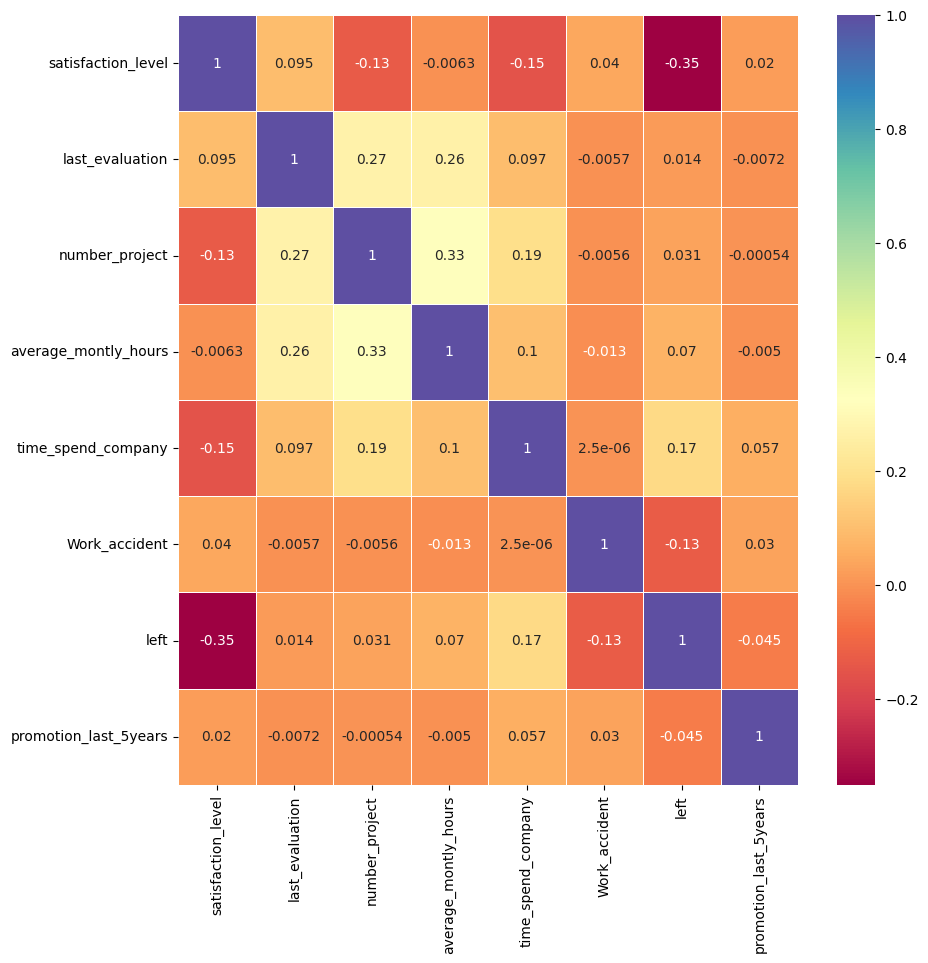

In [10]:
pltgrpaph.PlotHeatmap()

# last evaluattion and Number of project has strong co relation
#Average monthly hours and number of project has strong coreleation

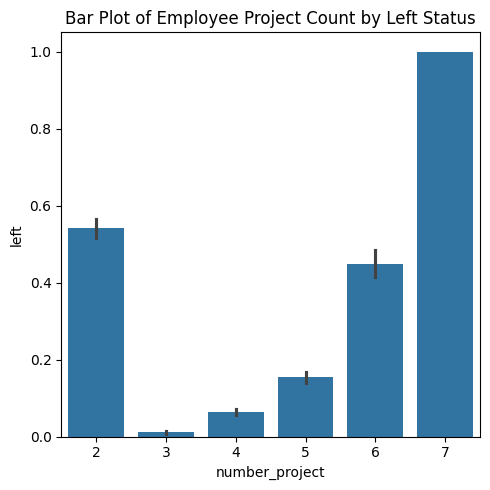

'\nEmployee who done 7 project has left the company\n50% of employee who handeled 2 project and 6 Project has left the company\nless than 10% of employee who handled 3 project has left the company\n'

In [11]:
pltgrpaph.BarplotGraph()

'''
Employee who done 7 project has left the company
50% of employee who handeled 2 project and 6 Project has left the company
less than 10% of employee who handled 3 project has left the company
'''

In [12]:
class DatasetTransformation:
  def __init__(self,df):
    self.df = df_Employee

  def TransformCategorical(self):
    df_Employee = self.df.copy()
    categorical_columns = self.df.select_dtypes(include=['object']).columns
    self.df = pd.get_dummies(df_Employee['Department'], prefix = 'Deptatment',dtype=int)

    df_Employee = pd.concat([df_Employee,self.df],axis=1)
    df_Employee = df_Employee.drop(['Department'],axis=1)

    label_encoder = LabelEncoder()
    df_Employee['salary'] = label_encoder.fit_transform(df_Employee['salary'])

    return df_Employee




ObjTrans = DatasetTransformation(df_Employee)
df_Employee_Transformed = ObjTrans.TransformCategorical()

In [13]:
df_Employee_Transformed.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,Deptatment_IT,Deptatment_RandD,Deptatment_accounting,Deptatment_hr,Deptatment_management,Deptatment_marketing,Deptatment_product_mng,Deptatment_sales,Deptatment_support,Deptatment_technical
0,0.38,0.53,2,157,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,2,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,2,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [14]:
class DatasetSplit:
  def __init__(self,df):
    self.df = df_Employee_Transformed

  def SplitDataset(self):
    Attribute_Train, Attribute_Test, Feature_Train, Feature_Test = train_test_split(self.df.drop('left',axis=1),self.df['left'],test_size=0.2,random_state=123)

    sc = StandardScaler()
    Attribute_Train_scaled = sc.fit_transform(Attribute_Train)
    Attribute_Test_scaled = sc.transform(Attribute_Test)

    smote = SMOTE(random_state=123)
    Attribute_Train_resample, Feature_Train_resample = smote.fit_resample(Attribute_Train_scaled, Feature_Train)





    return Attribute_Train_resample, Attribute_Test_scaled, Feature_Train_resample, Feature_Test


ObjSplit = DatasetSplit(df_Employee_Transformed)
Attribute_Train_resample, Attribute_Test_scaled, Feature_Train_resample, Feature_Test = ObjSplit.SplitDataset()



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [15]:
class ModelFitAndPrediction:
  def __init__(self,Attribute_Train_resample, Attribute_Test_scaled, Feature_Train_resample, Feature_Test):
    self.Attribute_Train_resample = Attribute_Train_resample
    self.Attribute_Test_scaled = Attribute_Test_scaled
    self.Feature_Train_resample = Feature_Train_resample
    self.Feature_Test = Feature_Test
    self.df_Metrics = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall','F1 Score'])

  def LogisticModel(self):
    logit_model = LogisticRegression(max_iter=1000, random_state= 123)
    logit_model.fit(self.Attribute_Train_resample,self.Feature_Train_resample)

    self.PredictonFunction(logit_model,'Logistic Regression')

    return self.df_Metrics

  def RandomForestClassifierModel(self):
    rndmFrst_clsfr = RandomForestClassifier(random_state=123)
    rndmFrst_clsfr.fit(self.Attribute_Train_resample,self.Feature_Train_resample)

    self.PredictonFunction(rndmFrst_clsfr,'Random Forest Classifier')

    return self.df_Metrics

  def GradientBoostingClassifierModel(self):
    gb_classifier = GradientBoostingClassifier(random_state=123)
    gb_classifier.fit(self.Attribute_Train_resample,self.Feature_Train_resample)

    self.PredictonFunction(gb_classifier,'Gradient Boosting Classifier')

    return self.df_Metrics


  def PredictonFunction(self, model_created,Model_Type):
    prediction_result = cross_val_predict(model_created,self.Attribute_Test_scaled,self.Feature_Test,cv=5)

    class_report = classification_report(self.Feature_Test,prediction_result,output_dict=True)
    df_class_report = pd.DataFrame(class_report).transpose()
    plt.figure(figsize=(5,5))
    sns.heatmap(df_class_report.iloc[:-1, :-1],annot=True, cmap='Spectral',fmt='.2f')
    plt.title(Model_Type+' Classification Report')
    plt.show()
    print(Model_Type,'Classification report: \n',class_report)

    accuracy = accuracy_score(self.Feature_Test,prediction_result)
    precision = class_report['1']['precision']
    recall = class_report['1']['recall']
    f1_score = class_report['1']['f1-score']
    new_row = pd.DataFrame([{'Model':Model_Type,'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1 Score':f1_score}])
    self.df_Metrics = pd.concat([self.df_Metrics, new_row], ignore_index=True)
    print(self.df_Metrics)


    print('Accuracy: ',accuracy)
    print('Precision: ',precision)
    print('Recall: ',recall)
    print('F1 Score: ',f1_score)
    conf_matrix = confusion_matrix(self.Feature_Test,prediction_result)

    confusion_label = np.asarray([["{0:0.0f}".format(item)+"\n{0:.2}".format(item/conf_matrix.flatten().sum())]
                                for item in conf_matrix.flatten()]).reshape(2,2)

    plt.figure(figsize=(3,3))
    sns.heatmap(conf_matrix,annot=confusion_label,cmap='Spectral',fmt='')
    plt.ylabel('Acutal')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix '+Model_Type)
    plt.tight_layout()
    plt.show()

    False_Positive_Rate, True_Positive_Rate, Thresholds = roc_curve(self.Feature_Test, prediction_result)
    roc_auc = auc(False_Positive_Rate, True_Positive_Rate)
    plt.figure(figsize=(5,3))
    plt.plot(False_Positive_Rate,True_Positive_Rate,label='AUC = %0.2f'%roc_auc)
    plt.plot([0,1],[0,1],color='green',lw=2,linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve '+Model_Type)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    return self.df_Metrics





modelObj = ModelFitAndPrediction(Attribute_Train_resample, Attribute_Test_scaled, Feature_Train_resample, Feature_Test)


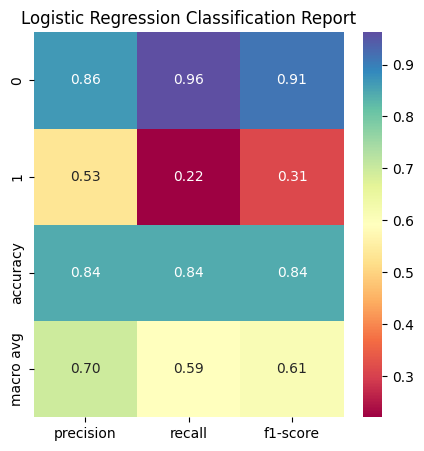

Logistic Regression Classification report: 
 {'0': {'precision': 0.8641037103263299, 'recall': 0.9621702339472374, 'f1-score': 0.9105040037682525, 'support': 2009.0}, '1': {'precision': 0.5308641975308642, 'recall': 0.2205128205128205, 'f1-score': 0.3115942028985507, 'support': 390.0}, 'accuracy': 0.8416006669445603, 'macro avg': {'precision': 0.6974839539285971, 'recall': 0.591341527230029, 'f1-score': 0.6110491033334016, 'support': 2399.0}, 'weighted avg': {'precision': 0.8099297169998473, 'recall': 0.8416006669445603, 'f1-score': 0.8131405930391221, 'support': 2399.0}}
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.841601   0.530864  0.220513  0.311594
Accuracy:  0.8416006669445603
Precision:  0.5308641975308642
Recall:  0.2205128205128205
F1 Score:  0.3115942028985507


<ipython-input-15-ccdb3ab3d249>:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_Metrics = pd.concat([self.df_Metrics, new_row], ignore_index=True)


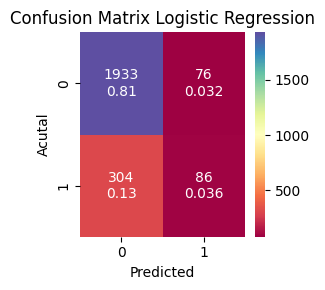

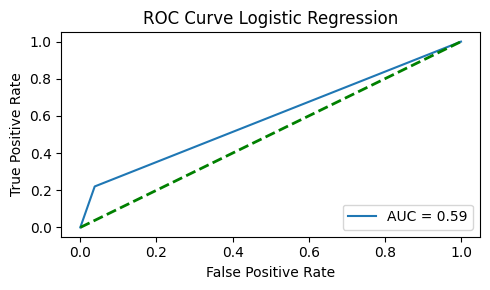

In [16]:
df_Final_Metrics = modelObj.LogisticModel()

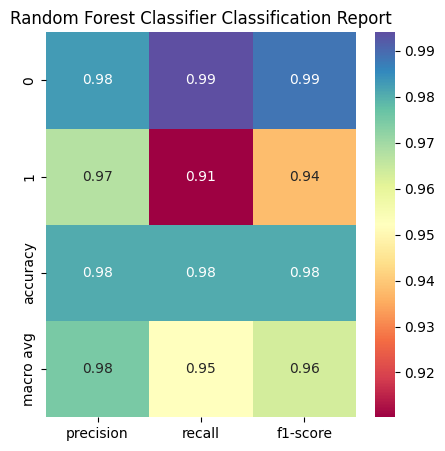

Random Forest Classifier Classification report: 
 {'0': {'precision': 0.9827755905511811, 'recall': 0.9940268790443006, 'f1-score': 0.9883692155407078, 'support': 2009.0}, '1': {'precision': 0.9673024523160763, 'recall': 0.9102564102564102, 'f1-score': 0.9379128137384413, 'support': 390.0}, 'accuracy': 0.980408503543143, 'macro avg': {'precision': 0.9750390214336286, 'recall': 0.9521416446503554, 'f1-score': 0.9631410146395745, 'support': 2399.0}, 'weighted avg': {'precision': 0.9802601574908681, 'recall': 0.980408503543143, 'f1-score': 0.980166632504908, 'support': 2399.0}}
                      Model  Accuracy  Precision    Recall  F1 Score
0       Logistic Regression  0.841601   0.530864  0.220513  0.311594
1  Random Forest Classifier  0.980409   0.967302  0.910256  0.937913
Accuracy:  0.980408503543143
Precision:  0.9673024523160763
Recall:  0.9102564102564102
F1 Score:  0.9379128137384413


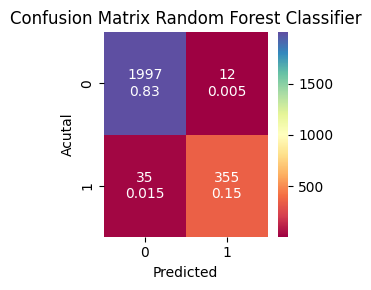

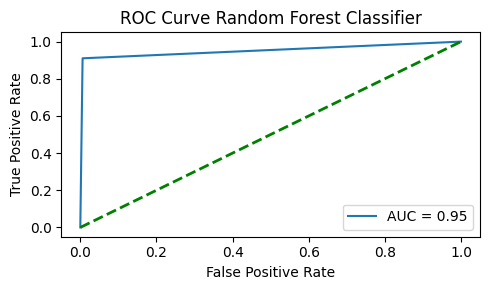

In [17]:
df_Final_Metrics = modelObj.RandomForestClassifierModel()

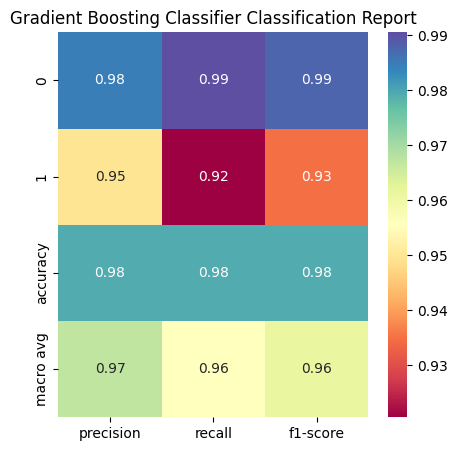

Gradient Boosting Classifier Classification report: 
 {'0': {'precision': 0.9846610588817417, 'recall': 0.9905425584868094, 'f1-score': 0.9875930521091811, 'support': 2009.0}, '1': {'precision': 0.9497354497354498, 'recall': 0.9205128205128205, 'f1-score': 0.9348958333333334, 'support': 390.0}, 'accuracy': 0.9791579824927052, 'macro avg': {'precision': 0.9671982543085957, 'recall': 0.9555276894998149, 'f1-score': 0.9612444427212572, 'support': 2399.0}, 'weighted avg': {'precision': 0.9789832816549582, 'recall': 0.9791579824927052, 'f1-score': 0.9790261845299478, 'support': 2399.0}}
                          Model  Accuracy  Precision    Recall  F1 Score
0           Logistic Regression  0.841601   0.530864  0.220513  0.311594
1      Random Forest Classifier  0.980409   0.967302  0.910256  0.937913
2  Gradient Boosting Classifier  0.979158   0.949735  0.920513  0.934896
Accuracy:  0.9791579824927052
Precision:  0.9497354497354498
Recall:  0.9205128205128205
F1 Score:  0.9348958333333334


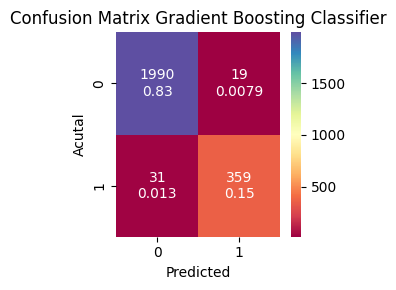

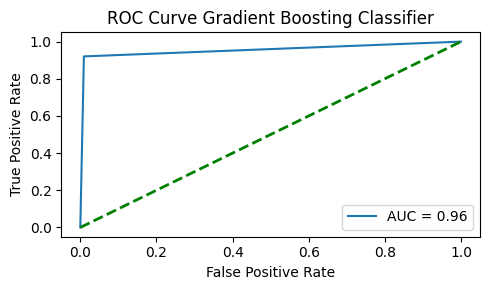

In [18]:
df_Final_Metrics = modelObj.GradientBoostingClassifierModel()

In [19]:
df_Final_Metrics

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.841601,0.530864,0.220513,0.311594
1,Random Forest Classifier,0.980409,0.967302,0.910256,0.937913
2,Gradient Boosting Classifier,0.979158,0.949735,0.920513,0.934896


In [20]:
class BestFitModel():
  def __init__(self,Attribute_Train_resample, Attribute_Test_scaled, Feature_Train_resample, Feature_Test):
    self.Attribute_Train_resample = Attribute_Train_resample
    self.Attribute_Test_scaled = Attribute_Test_scaled
    self.Feature_Train_resample = Feature_Train_resample
    self.Feature_Test = Feature_Test
    self.df_Metrics = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall','F1 Score'])

  def BestFitModel(self):
    best_model = RandomForestClassifier(random_state=123)
    best_model.fit(self.Attribute_Train_resample,self.Feature_Train_resample)

    Proab_Prediction = best_model.predict_proba(self.Attribute_Test_scaled)[:,1]
    # Categorize employees based on the probability scores
    zones = pd.cut(Proab_Prediction, bins=[0, 0.2, 0.6, 0.9, 1], labels=["Green", "Yellow", "Orange", "Red"])

    # Create a DataFrame to display the zones
    zone_df = pd.DataFrame({'Employee': range(len(Proab_Prediction)), 'Probability': Proab_Prediction, 'Zone': zones})

    zone_df['Retention_Strategy'] = zone_df['Zone'].apply(self.suggest_retention_strategies)
    print(zone_df[['Employee', 'Probability', 'Zone', 'Retention_Strategy']])




    fpr, tpr, thresholds = roc_curve(self.Feature_Test, Proab_Prediction)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,3))
    plt.plot(fpr,tpr,label='AUC = %0.2f'%roc_auc)
    plt.plot([0,1],[0,1],color='green',lw=2,linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve '+'Random Forest Classifier')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    class_report = classification_report(self.Feature_Test,best_model.predict(self.Attribute_Test_scaled),output_dict=True)
    df_class_report = pd.DataFrame(class_report).transpose()
    plt.figure(figsize=(5,5))
    sns.heatmap(df_class_report.iloc[:-1, :-1],annot=True, cmap='Spectral',fmt='.2f')
    plt.title('Random Forest Classifier Classification Report')
    plt.show()

    conf_Matrix = confusion_matrix(self.Feature_Test,best_model.predict(self.Attribute_Test_scaled))
    con_labels = np.asarray([["{0:0.0f}".format(item)+"\n{0:.2}".format(item/conf_Matrix.flatten().sum())]
                                for item in conf_Matrix.flatten()]).reshape(2,2)
    plt.figure(figsize=(3,3))
    sns.heatmap(conf_Matrix,annot=con_labels,cmap='Spectral',fmt='')
    plt.ylabel('Acutal')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix Random Forest Classifier')
    plt.tight_layout()
    plt.show()

    return best_model

  def suggest_retention_strategies(self,zone):
    if zone == "Green":
        return "Maintain current conditions. Continue providing a supportive work environment to keep employees engaged."
    elif zone == "Yellow":
        return "Monitor employee satisfaction and engagement closely. Provide opportunities for growth and development."
    elif zone == "Orange":
        return "Increase efforts to understand and address employee concerns. Offer incentives and recognition to improve retention."
    elif zone == "Red":
        return "Take immediate action to address critical issues. Offer personalized retention plans and career development opportunities."




      Employee  Probability    Zone  \
0            0         0.01   Green   
1            1         0.08   Green   
2            2         0.18   Green   
3            3         0.27  Yellow   
4            4         0.04   Green   
...        ...          ...     ...   
2394      2394         0.01   Green   
2395      2395         0.00     NaN   
2396      2396         0.02   Green   
2397      2397         0.09   Green   
2398      2398         0.00     NaN   

                                     Retention_Strategy  
0     Maintain current conditions. Continue providin...  
1     Maintain current conditions. Continue providin...  
2     Maintain current conditions. Continue providin...  
3     Monitor employee satisfaction and engagement c...  
4     Maintain current conditions. Continue providin...  
...                                                 ...  
2394  Maintain current conditions. Continue providin...  
2395                                                NaN  
2396  Mai

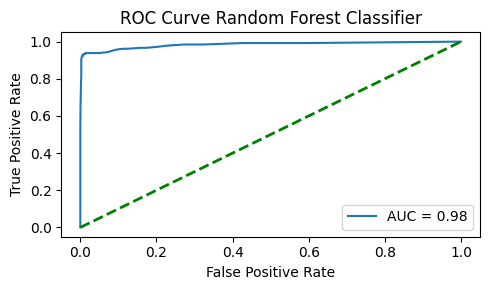

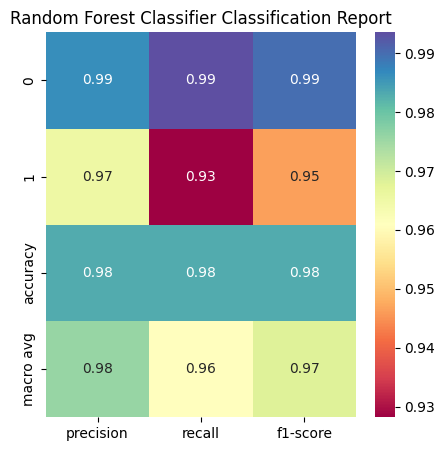

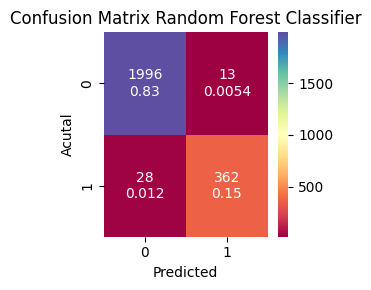

In [21]:
bestModelObj = BestFitModel(Attribute_Train_resample, Attribute_Test_scaled, Feature_Train_resample, Feature_Test)
best_model = bestModelObj.BestFitModel()

#Retention Strategies
Safe Zone (Green): Maintain current conditions and continue providing a supportive work environment.

Low-Risk Zone (Yellow): Monitor satisfaction and engagement closely, and offer growth opportunities.

Medium-Risk Zone (Orange): Increase efforts to understand and address concerns, and provide incentives and recognition.

High-Risk Zone (Red): Take immediate action to address critical issues and offer personalized retention plans.